In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import os
import glob
from numpy.random import seed
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from keras import Model
import logging

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Fix random seeds for reproducibility
seed(1)
tf.random.set_seed(1)

# Load and prepare data

In [ ]:
# 4 most traded cryptocurrencies in the past year
cryptos = ['BITCOIN (BTC)', 'TRON (TRX)', 'Cardano (ADA)', 'Binance Coin (BNB)']

all_data = {}
for crypto in cryptos:
    try:
        # Dynamically create ticker symbol from the crypto name
        ticker = crypto[-4:-1] + '-USD'
        logging.info(f"Downloading data for {crypto} with ticker {ticker}")
        t = yf.Ticker(ticker)
        t_data = t.history(start="2018-01-01", end="2024-01-01", interval="1d")
        
        if t_data.empty:
            logging.warning(f"No data found for {crypto}. Skipping.")
            continue
        
        t_data.index = t_data.index.date
        t_data.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
        all_data[crypto] = t_data
        
    except Exception as e:
        logging.error(f"Error downloading data for {crypto}: {e}")

To evaluate the models’ performances, we need to compare predicted values of volatility with its actual values, however, volatility is an unobservable variable, and it is not measurable. Since standard deviation indicates how much a cryptocurrency has varied during a certain period, we can use this feature as a proxy for volatility. Therefore, historical volatility at day t is calculated as standard deviations of the returns’ values using the following equation where:


*   r_i: the return value of cryptocurrency on day i
*   (r_t)_: the average return value of cryptocurrency during past T trading days
*   T=30 (approximately one month of transactions) 


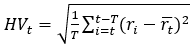

Update: Code incorporates trading volume and technical indicators like the Moving Average Convergence Divergence (MACD) and Relative Strength Index (RSI)
* Moving average convergence/divergence (MACD) is a technical indicator to help investors identify market entry points for buying or selling. The MACD line is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA. The signal line is a nine-period EMA of the MACD line.
* The relative strength index (RSI) is a momentum indicator used in technical analysis. RSI measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price of that security.


$$RSI = 100 - \frac{100}{1 + \frac{AverageGain}{AverageLoss}}$$
The average gain or loss used in this calculation is the average percentage gain or loss during a look-back period which is 14 days (2 weeks) in our code.

In [ ]:
# Function to calculate MACD
def calculate_macd(data):
    short_ema = data['Close'].ewm(span=12, adjust=False).mean()
    long_ema = data['Close'].ewm(span=26, adjust=False).mean()
    macd = short_ema - long_ema
    macd_signal = macd.ewm(span=9, adjust=False).mean()
    return macd, macd_signal

# Function to calculate RSI
def calculate_rsi(data, period=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Correct the feature engineering part where MACD, MACD signal, and RSI are calculated.
for crypto in all_data.keys(): 
    try:
        # Calculate log-returns: log_ret = log(Close_t) - log(Close_(t-1))
        log_ret = np.log(all_data[crypto].Close) - np.log(all_data[crypto].Close.shift(1)) 
        all_data[crypto]['returns'] = log_ret
        
        # Calculate Historical Volatilities
        all_data[crypto]['HV'] = np.nan
        for i in range(30, len(all_data[crypto])):
            sample = all_data[crypto]['returns'][i-30:i].tolist()
            all_data[crypto].loc[all_data[crypto].index[i], 'HV'] = statistics.stdev(sample)

        # Calculate MACD and RSI correctly with all_data[crypto]
        all_data[crypto]['MACD'], all_data[crypto]['MACD_signal'] = calculate_macd(all_data[crypto])
        all_data[crypto]['RSI'] = calculate_rsi(all_data[crypto])
        
        # Handle infinite values and drop NaNs
        all_data[crypto]['returns'].replace([np.inf, -np.inf], 0.000001, inplace=True)
        all_data[crypto].dropna(inplace=True)  # The first 30 values of HV will be NaNs
        all_data[crypto].drop(['Close', 'returns'], axis=1, inplace=True)  # Drop unnecessary columns
    except Exception as e:
        logging.error(f"Error processing data for {crypto}: {e}") 

## See an example:
all_data['BITCOIN (BTC)']

In [ ]:
# Line plots of Historical Volatility for each cryptocurrency
for key, value in all_data.items():
    try:
        plt.figure(figsize=(18, 6))
        plt.plot(value['HV'].values, color='blue', label=key)
        plt.title(f'{key} HV Over Time', fontsize=18)
        plt.ylabel('HV')
        plt.legend()
        plt.show()
    except Exception as e:
        logging.error(f"Error plotting HV for {key}: {e}")

# Line plots of MACD for each cryptocurrency
for key, value in all_data.items():
    try:
        plt.figure(figsize=(18, 6))
        plt.plot(value['MACD'].values, color='blue', label='MACD')
        plt.plot(value['MACD_signal'].values, color='red', label='MACD Signal')
        plt.title(f'{key} MACD and MACD Signal Over Time', fontsize=18)
        plt.ylabel('MACD')
        plt.legend()
        plt.show()
    except Exception as e:
        logging.error(f"Error plotting MACD for {key}: {e}")

# Line plots of RSI for each cryptocurrency
for key, value in all_data.items():
    try:
        plt.figure(figsize=(18, 6))
        plt.plot(value['RSI'].values, color='green', label='RSI')
        plt.axhline(y=70, color='red', linestyle='--', label='Overbought')
        plt.axhline(y=30, color='blue', linestyle='--', label='Oversold')
        plt.title(f'{key} RSI Over Time', fontsize=18)
        plt.ylabel('RSI')
        plt.legend()
        plt.show()
    except Exception as e:
        logging.error(f"Error plotting RSI for {key}: {e}")

Each dataset will be divided into two parts: the first 80% as the training sample, and the remaining 20% as the testing sample. Moreover, for the purpose of hyper-parameter tuning of deep learning models, the last 20% of the training sample will be used as the validation sample. 

In [ ]:
#### data split parameters
example_data = all_data['BITCOIN (BTC)']
train_valid_size = int(0.8*len(example_data))
valid_size = int(0.2*(0.8*len(example_data)))
train_size = train_valid_size - valid_size 
test_size = len(example_data) - int(0.8*len(example_data))

print("size of the train_valid set: ", train_valid_size)
print("size of the train set: ", train_size)
print("size of the validation set: ", valid_size)
print("size of the test set: ", test_size)
print('total: ', train_size + valid_size + test_size)

The `prepare_input()` function prepares training, validation, and testing samples for each cryptocurrency dataset. 
`Feature` specifies the input data and `h` defines how many lags of input data should be used in training set construction. In other words, the objective is to train the models such that h lagged values of HV_t are fed as an input vector to predict HV_t. 
In this notebook, `Feature = ['HV']` and `h = 6` (approximately one week of transactions) will be used. 
*   For the purpose of hyper-parameter tuning on validation set, use the function as `prepare_input(data, train_size, valid_size, feature, h)`
*   For the purpose of evaluating the models on test set, use the function as `prepare_input(data, train_valid_size, test_size, feature, h)`





In [ ]:
def prepare_input(data, train_size, valid_size, features, h):
    try:
        for feature in features:
            if feature not in data.columns:
                raise ValueError(f"Feature '{feature}' not found in data columns.")
        
        if len(data) < train_size + valid_size + h:
            raise ValueError("Not enough data points to create training and validation sets with the specified sizes and time-steps.")
        
        train_set = data[features].iloc[:train_size].values
        valid_set = data[features].iloc[train_size:train_size + valid_size].values
        
        # Feature Scaling
        sc = MinMaxScaler(feature_range=(0, 1))
        train_set_scaled = sc.fit_transform(train_set)
        
        # Creating a data structure with h time-steps and multiple features as output
        X_train, y_train = [], []
        for i in range(h, train_size):
            X_train.append(train_set_scaled[i-h:i])
            y_train.append(train_set_scaled[i, 0])  # Adjusted to get the correct feature
        
        X_train, y_train = np.array(X_train), np.array(y_train)
        
        # Preparing the validation set for making predictions
        dataset_train_valid = pd.concat((data[features].iloc[:train_size], data[features].iloc[train_size:train_size + valid_size]), 
                                        axis=0)
        valid_h = dataset_train_valid[len(dataset_train_valid) - len(data[features].iloc[train_size:train_size + valid_size]) - h:].values
        if len(valid_h) < h:
            raise ValueError("Validation set is too short for the specified time-steps.")
        valid_h = sc.transform(valid_h)
        
        X_valid = []
        for i in range(h, valid_h.shape[0]):
            X_valid.append(valid_h[i-h:i])
        X_valid = np.array(X_valid)
        
        return X_train, y_train, X_valid, data['HV'][train_size:train_size + valid_size], train_set_scaled
    except ValueError as ve:
        logging.error(f"ValueError in prepare_input: {ve}")
        raise
    except Exception as e:
        logging.error(f"Error preparing input data: {e}")
        raise

# Create models and define necessary functions

In [ ]:
def create_single_model(model_name, layer_number, hidden_units, dense_units, Dropout_layer, input_shape, activation, dropout_rate=0.2):
    """
    Creates a model using Keras Functional API based on specified parameters.
    
    Parameters:
    - model_name: str, type of model ('RNN', 'LSTM', 'BiLSTM')
    - layer_number: int, number of RNN/LSTM layers
    - hidden_units: int, number of units in each layer
    - dense_units: int, number of units in dense layer
    - Dropout_layer: bool, whether to include dropout layers
    - input_shape: tuple, shape of the input data
    - activation: str, activation function to use in hidden layers
    - dropout_rate: float, dropout rate (default is 0.2)

    Returns:
    - model: Keras Model object
    """
    
    hidden_units = int(hidden_units)  # Ensure hidden_units is an integer
    
    input_layer = Input(shape=input_shape)
    
    if model_name == "RNN":
        x = input_layer
        for _ in range(layer_number):
            x = SimpleRNN(hidden_units, return_sequences=True if _ < layer_number - 1 else False, activation=activation)(x)
    elif model_name == "LSTM":
        x = input_layer
        for _ in range(layer_number):
            x = LSTM(hidden_units, return_sequences=True if _ < layer_number - 1 else False, activation=activation)(x)
    elif model_name == "BiLSTM":
        x = input_layer
        for _ in range(layer_number):
            x = Bidirectional(LSTM(hidden_units, return_sequences=True if _ < layer_number - 1 else False, activation=activation))(x)
    else:
        raise ValueError("Invalid model_name. Choose from 'RNN', 'LSTM', or 'BiLSTM'.")
    
    # Optionally add dropout
    if Dropout_layer:
        x = Dropout(dropout_rate)(x)
    
    # Dense layers after RNN/LSTM layers
    z = Dense(dense_units, activation=activation)(x)
    
    # Optionally add batch normalization
    z = BatchNormalization()(z)
    
    # Final output layer
    output_layer = Dense(1, activation='linear')(z)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    return model


To evaluate each model’s performance, we will use the Coefficient of determination (R2_Score): Indicates how well the model's predictions match the actual values, with 1 meaning perfect predictions and 0 meaning the model is no better than a simple mean. 
The R-squared (coefficient of determination) is given by:

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

where:
- \( $y_i$ \) is the actual value,
- \( $\hat{y}_i$ \) is the predicted value,
- \( $\bar{y}$ \) is the mean of the actual values,
- \( n \) is the number of observations.


In [ ]:
# Model evaluation function with error handling
def model_evaluation(Tuning, model_name, layer_number, hidden_units, dense_units, 
                     Dropout_layer, input_shape, activation, loss, optimizer, epochs, batch_size):
    try:
        model = create_single_model(model_name, layer_number, hidden_units, dense_units, 
                                    Dropout_layer, input_shape, activation)
        model.compile(loss=loss, optimizer=optimizer)
        model_fit = model.fit(x=inputs[0], y=inputs[1], epochs=epochs, batch_size=batch_size, verbose=0)
        predicted_HV = model.predict(inputs[2])
        
        # Correct the reference to 'HV' in the model_evaluation() function
        sc2 = MinMaxScaler(feature_range=(0, 1))
        just_to_fit = data['HV'].iloc[train_size:train_valid_size].values if Tuning else data['HV'].iloc[train_valid_size:train_valid_size + test_size].values
        just_to_fit = just_to_fit.reshape(len(just_to_fit), 1)
        just_to_inverse = sc2.fit_transform(just_to_fit)

        predicted_HV = sc2.inverse_transform(predicted_HV)
        predicted_HV = predicted_HV.reshape(-1)
        R2_Score = r2_score(inputs[3]['HV'].values, predicted_HV)
        return R2_Score, predicted_HV
    except Exception as e:
        logging.error(f"Error during model evaluation: {e}")
        raise

# Experiments: validating and testing the models



In order to find an approximate value for the `epochs`, some trial and error was done in the following code, and training for at most 10 epochs was found to be enough. However, a more exact value for this hyper-parameter can be found via hyper-parameter tuning.  

In [ ]:
example_data = all_data['BITCOIN (BTC)']
inputs = prepare_input(example_data, train_valid_size, test_size, ['HV', 'MACD', 'MACD_signal', 'RSI', 'Volume'], 6)
model = create_single_model('RNN', 1, 50, 64, True, (6, 1), 'tanh')
model.compile(loss='mse', optimizer='RMSprop')
model_fit = model.fit(x=inputs[0], y=inputs[1], epochs = 5, batch_size = 32, verbose=1)        ## after some trial and error,  training for at most 5 epochs was found to be enough 
## Plot losses
plt.figure(figsize=(18,6))
plt.title('Training loss plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(model_fit.history['loss'], color = 'orange', label = 'training loss')
plt.legend()

predicted_HV = model.predict(inputs[2]) 

# Inversion of Predicted Values to Original Scale
sc2 = MinMaxScaler(feature_range=(0, 1))
just_to_fit = data['HV'].iloc[:train_valid_size].values.reshape(-1, 1)  # Fit on entire training+validation data
just_to_inverse = sc2.fit_transform(just_to_fit)
predicted_HV = sc2.inverse_transform(predicted_HV)

predicted_HV = predicted_HV.reshape(-1)
R2_Score = r2_score(inputs[3]['HV'].values, predicted_HV)
print(R2_Score)

The most important hyper-parameters will be tuned using grid search method on the validation set. Consequently, the models’ structures vary from one cryptocurrency to another as each model yields a specific set of optimal hyper-parameters for each cryptocurrency. The results of tuning for each crypto-model combination will be saved as a CSV file on Google Drive folder. 

In [ ]:
from joblib import Parallel, delayed

def tune_model(crypto, model_name, layer_number, hidden_units, dense_units, activation, batch_size):
    R2_tun = model_evaluation(True, model_name, layer_number, hidden_units, dense_units, True, input_shape, activation, loss, optimizer, epochs, batch_size)[0]
    return [crypto, model_name, layer_number, hidden_units, dense_units, activation, batch_size, R2_tun]

### Hyper-parameter tuning

layer_numbers = [1, 2, 3, 4]  
hidden_units_set = [50, 75, 100, 150]  
dense_units_set = [64, 96, 128, 160]  
activations = ['tanh', 'relu', 'sigmoid']  
batch_sizes = [16, 32, 64]  
optimizer = 'RMSprop'                                      
loss = 'mean_squared_error'
epochs = 5
feature = ['HV', 'MACD', 'MACD_signal', 'RSI', 'Volume']
h = 14                                                          ## 2 week of transactions
model_names = ['RNN', 'LSTM']

## A folder on Google Drive for saving the results of hyper-parameter tuning
os.chdir("C:\\Users\\LENOVO\\Downloads\\output_cvproject")  

# Parallel tuning
for key, value in all_data.items():
    data = value
    crypto = key
    inputs = prepare_input(data, train_size, valid_size, feature, h)
    input_shape = (inputs[0].shape[1], inputs[0].shape[2])

    for model_name in model_names:
        combinations = [(crypto, model_name, ln, hu, du, act, bs) for ln in layer_numbers
                        for hu in hidden_units_set for du in dense_units_set 
                        for act in activations for bs in batch_sizes]
        
        tun_results = Parallel(n_jobs=-1)(delayed(tune_model)(*params) for params in combinations)

        tun_results_df = pd.DataFrame(tun_results, columns=["crypto", "model_name", "layer_number", 
                                                            "hidden_units", "dense_units", "activation", "batch_size",
                                                              "R2_tun"])
        tun_results_df = tun_results_df.sort_values('R2_tun')
        tun_results_df.to_csv(crypto + ' ' + model_name + '.csv')
        print(crypto + ' ' + model_name + ' tuning ' + 'is done')

Since the tuning results were sorted by R2 Score values, the first row of each file is related to the optimized parameters. We can load all csv files and use the first row of each file (indicate by` iloc[0]` in the code) as the optimized parameters in our testing section.


In [ ]:
# Check for empty or invalid CSV files during processing
for t in tun_filenames:
    if os.path.getsize(t) > 0:  # Only read non-empty files
        df = pd.read_csv(t)
        if not df.empty and 'crypto' in df.columns and 'model_name' in df.columns:
            tun_data[t.replace('.csv', '')] = df
        else:
            logging.warning(f"File {t} is missing required columns or is empty.")
    else:
        logging.warning(f"File {t} is empty or could not be loaded.")

In [ ]:
for key, value in sorted(tun_data.items()):
  print(key, value, sep = '\n')

In [ ]:
seed(1)
tf.random.set_seed(1)

# Initialize lists to store R2_Score results and predicted values
R2_results = []
Predicted_values = []

# Loop through each cryptocurrency's tuning data
for key, value in sorted(tun_data.items()):
    try:
        # Extract relevant information
        crypto = tun_data[key].iloc[0]['crypto']
        model_name = tun_data[key].iloc[0]['model_name']
        print(f"Evaluating model: {model_name} for crypto: {crypto}")

        # Prepare input data for the model
        data = all_data[crypto]
        inputs = prepare_input(data, train_valid_size, test_size, feature, h) 
        input_shape = (inputs[0].shape[1], inputs[0].shape[2])

        # Perform model evaluation using the best hyperparameters from tuning
        evaluation_result = model_evaluation(
            Tuning=False,
            model_name=model_name,
            layer_number=tun_data[key].iloc[0]['layer_number'],
            hidden_units=tun_data[key].iloc[0]['hidden_units'],
            dense_units=tun_data[key].iloc[0]['dense_units'],
            Dropout_layer=True,
            input_shape=input_shape,
            activation=tun_data[key].iloc[0]['activation'],
            loss=loss,
            optimizer=optimizer,
            epochs=epochs,
            batch_size=tun_data[key].iloc[0]['batch_size']
        )

        # Store the R2_Score result and predicted values
        R2_results.append([crypto, model_name, evaluation_result[0]])
        Predicted_values.append(evaluation_result[1])

    except Exception as e:
        print(f"Error processing {crypto} with model {model_name}: {e}")

# Create a DataFrame from R2_Score results for better visualization
R2_results_df = pd.DataFrame(R2_results, columns=["crypto", "model_name", "R2_test"])

# Display the DataFrame
print(R2_results_df)

In [ ]:
#### Plots of predicted vs. real HV
for i in [0, 3, 6, 9]:
  crypto = R2_results_df.iloc[i]['crypto']
  data = all_data[crypto]
  inputs = prepare_input(data, train_valid_size, test_size, feature, h) 
  plt.figure(figsize=(18,6))
  plt.title("Predicted vs. real HV - " + crypto + " - test set")
  plt.plot( inputs[3]['HV'].values, color = 'gray', label = 'HV')
  plt.plot(Predicted_values[i], color = 'red', label = R2_results_df.iloc[i]['model_name'] + '_HV')
  plt.plot(Predicted_values[i+1], color = 'blue', label = R2_results_df.iloc[i+1]['model_name'] +'_HV')
  plt.plot(Predicted_values[i+2], color = 'green', label = R2_results_df.iloc[i+2]['model_name'] +'_HV')

  plt.xlabel('Day')
  plt.ylabel('HV')
  plt.legend()
  plt.show()


In [ ]:
# Ensure that 'i', 'i+1', and 'i+2' do not go out of bounds for 'Predicted_values' and 'R2_results_df'
for i in range(0, len(R2_results_df), 3):
    crypto = R2_results_df.iloc[i]['crypto']
    data = all_data[crypto]
    inputs = prepare_input(data, train_valid_size, test_size, feature, h) 

    plt.figure(figsize=(18, 6))
    plt.title(f"Predicted vs. Real HV - {crypto} - Test Set")
    plt.plot(inputs[3]['HV'].values, color='gray', label='Real HV')

    # Plot up to three models' predictions if they exist
    for j, color in zip(range(3), ['red', 'blue', 'green']):
        if i + j < len(Predicted_values):
            plt.plot(Predicted_values[i + j], color=color, label=f"{R2_results_df.iloc[i + j]['model_name']}_HV")

    plt.xlabel('Day')
    plt.ylabel('HV')
    plt.legend()
    plt.show()
